In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
from scipy.io import loadmat, savemat
from scipy.stats import binom

# Running the classification form of the model free of classes
In this notebook, we construct the model purely as a classifier with no pretraining. We have ample data to do this synthetically, so we can show the validity of the model. 

Again, we're assuming something about the data. Namely, there are 
 * $K$ kinds of instances, each with $N_k$ instances.
 * Each kind will have $M_k$ features
 * There is an assumed latent binary label for each instance, $Y_{k, n}$.
 * The label of the total bag will be $0$ if and only if all $Y_{k, n} = 0$
 
Note that the model complexity is very small, but capable of managing the multiple-instance structure of the data which gives the data so many raw features. If we have hidden layers of size $h$, there are only $$h \sum_0^{K-1}{(M_k+N_k)}$$ parameters. This is due to the convolutional first layer, which replaces a dense first layer having $$h \sum_0^{K-1}{(M_k \cdot N_k)}$$ parameters. The reduction in parameters is intentional in order to reduce overfitting especially when there are very few training examples.

The second formulation of the model even further reduces the number of parameters while retaining the ability to correcly classify all of the examples by weighting all baskets the same. We assume $h=1$ and introduce a learned scaling parameter that scales the sum of the submodels to make a consensus. Thus, we have $$\sum_0^{K-1}{M_k}$$ parameters. This reduction in parameters not only protects against overfitting, but also reduces the complexity of training - the fewer parameters, the easier it is to train, generally.

In [45]:
K = 2
M = [30, 35]
N = [10, 15]
batch_size = 10
hidden_layer_size = 1

In [46]:
def accuracy(y_true, y_pred):
    return 1 - ((np.round(y_pred) - y_true)**2).sum() / len(y_true)

In [47]:
from sklearn.metrics import roc_auc_score

In [48]:
synth_data = loadmat('./synth_dataset.mat')
synth_data

trainX = synth_data['train_X']
trainY = np.ravel(synth_data['train_Y'])

testX = synth_data['test_X'].reshape(-1, sum(m*n for m, n in zip(M, N)), 1)
testY = np.ravel(synth_data['test_Y']).reshape(-1, 1)


shuffle_idx = np.random.permutation(np.arange(len(trainX)))
trainX = trainX[shuffle_idx]
trainY = trainY[shuffle_idx]
validX = trainX[:len(trainX)//4].reshape(-1, sum(m*n for m, n in zip(M, N)), 1)
validY = trainY[:len(trainY)//4].reshape(-1, 1)
trainX = trainX[len(trainX)//4:].reshape(-1, sum(m*n for m, n in zip(M, N)), 1)
trainY = trainY[len(trainY)//4:].reshape(-1, 1)

In [49]:
np.ravel(testYFull.max(axis=1)) == np.ravel(testY)

array([False,  True, False, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False,  True, False,
        True,  True, False,  True, False,  True,  True,  True, False,
        True, False,  True,  True,  True,  True, False, False, False,
        True, False,  True,  True,  True, False, False,  True, False,
       False, False,  True,  True, False,  True,  True,  True,  True,
       False, False,  True, False,  True,  True,  True, False, False,
       False, False, False,  True,  True,  True, False,  True, False,
        True, False,  True, False, False, False, False,  True, False,
       False,  True, False, False, False,  True,  True, False, False,
        True, False, False, False,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
       False, False,  True, False, False,  True, False, False, False,
        True,  True, False,  True,  True, False,  True,  True, False,
        True,  True,

In [50]:
trainX.shape

(563, 825, 1)

In [51]:
for k in range(K):
    idx = sum(N[_k]*M[_k] for _k in range(0, k))
    next_idx = N[k]*M[k] + idx
    trainX[:, idx:next_idx].reshape((len(trainX), N[k], M[k])).mean(axis=(0, 1))
    q1 = np.percentile(trainX[:, idx:next_idx].reshape((len(trainX), N[k], M[k])), 25, axis=(0, 1))
    q3 = np.percentile(trainX[:, idx:next_idx].reshape((len(trainX), N[k], M[k])), 75, axis=(0, 1))
    q2 = np.percentile(trainX[:, idx:next_idx].reshape((len(trainX), N[k], M[k])), 50, axis=(0, 1))
    trainX[:, idx:next_idx] = ((trainX[:, idx:next_idx].reshape((len(trainX), N[k], M[k])) - q3) / (q3 - q1)).reshape((len(trainX), -1, 1))
    validX[:, idx:next_idx] = ((validX[:, idx:next_idx].reshape((len(validX), N[k], M[k])) - q3) / (q3 - q1)).reshape((len(validX), -1, 1))
    testX[:, idx:next_idx] = ((testX[:, idx:next_idx].reshape((len(testX), N[k], M[k])) - q3) / (q3 - q1)).reshape((len(testX), -1, 1))

In [52]:
graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, sum(m*n for m,n in zip(M, N)), 1))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, 1))
    tf_valid_dataset = tf.constant(validX, tf.float32)
    tf_valid_labels = tf.constant(validY.reshape(-1,1), tf.float32)
    tf_test_dataset = tf.constant(testX, tf.float32)
    
    layer0_weights = []
    layer0_biases = []
    for k in range(K):
        kind_weights = tf.Variable(tf.truncated_normal([M[k], 1, hidden_layer_size], stddev=0.1))
        layer0_weights.append(kind_weights)
        
        kind_biases = tf.Variable(tf.zeros([hidden_layer_size]))
        layer0_biases.append(kind_biases)
        
    layer1_weights = tf.Variable(tf.truncated_normal([sum(N[k]*hidden_layer_size for k in range(K)), 1], stddev=0.1)) 
    layer1_biases = tf.Variable(tf.zeros([1]))
    
    def model(data):
        hidden_list = []
        for k in range(K):
            idx = sum(N[_k]*M[_k] for _k in range(0, k))
            next_idx = N[k]*M[k] + idx
            kind_conv = tf.nn.conv1d(data[:, idx:next_idx], layer0_weights[k], M[k], padding='VALID')
            kind_hidden = tf.nn.relu(kind_conv + layer0_biases[k])
            hidden_list.append(kind_hidden)

        hidden = tf.reshape(tf.concat(hidden_list, 1), (-1, sum(N[k]*hidden_layer_size for k in range(K))))
        logits = tf.matmul( hidden, layer1_weights) + layer1_biases
        return logits
    
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))    
    optimizer = tf.train.MomentumOptimizer(0.1, 0.7).minimize(loss)
    
    train_prediction = tf.nn.sigmoid(logits)
    valid_prediction = tf.nn.sigmoid(model(tf_valid_dataset))
    test_prediction = tf.nn.sigmoid(model(tf_test_dataset))
    
    train_accuracy = 1 - tf.reduce_mean(tf.square((tf.round(train_prediction) - tf_train_labels)))
    valid_accuracy = 1 - tf.reduce_mean(tf.square((tf.round(valid_prediction) - tf_valid_labels)))
#     test_accuracy = tf.reduce_sum(tf.square((tf.round(test_prediction) - tf)))    


In [53]:
num_steps = 10001
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        offset = (step * batch_size) % (trainY.shape[0] - batch_size)
        batch_data = trainX[offset:(offset+batch_size)]
        batch_labels = trainY[offset:(offset+batch_size)]
        feed_dict = {tf_train_dataset: batch_data, 
                     tf_train_labels: batch_labels}
        _, l, batch_pred = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if step % 200 == 0:
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % (accuracy(batch_labels, batch_pred)*100))
            print('Validation accuracy: %.1f%%' % (valid_accuracy.eval()*100))
    print('Test accuracy: %.1f%%' % (accuracy(testY,test_prediction.eval())*100))       
    print('Test ROC AUC: %.1f%%' % (roc_auc_score(testY, test_prediction.eval())*100))

Minibatch loss at step 0: 0.695005
Minibatch accuracy: 40.0%
Validation accuracy: 49.2%
Minibatch loss at step 200: 0.615917
Minibatch accuracy: 70.0%
Validation accuracy: 74.9%
Minibatch loss at step 400: 0.100412
Minibatch accuracy: 100.0%
Validation accuracy: 91.4%
Minibatch loss at step 600: 0.085719
Minibatch accuracy: 100.0%
Validation accuracy: 97.3%
Minibatch loss at step 800: 0.116186
Minibatch accuracy: 100.0%
Validation accuracy: 98.9%
Minibatch loss at step 1000: 0.024227
Minibatch accuracy: 100.0%
Validation accuracy: 100.0%
Minibatch loss at step 1200: 0.030283
Minibatch accuracy: 100.0%
Validation accuracy: 100.0%
Minibatch loss at step 1400: 0.008113
Minibatch accuracy: 100.0%
Validation accuracy: 100.0%
Minibatch loss at step 1600: 0.013108
Minibatch accuracy: 100.0%
Validation accuracy: 100.0%
Minibatch loss at step 1800: 0.016367
Minibatch accuracy: 100.0%
Validation accuracy: 100.0%
Minibatch loss at step 2000: 0.005482
Minibatch accuracy: 100.0%
Validation accuracy

# This time there are no weights deciding which submodel to use. It's just a consensus

In [54]:
graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, sum(m*n for m,n in zip(M, N)), 1))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, 1))
    tf_valid_dataset = tf.constant(validX, tf.float32)
    tf_valid_labels = tf.constant(validY.reshape(-1,1), tf.float32)
    tf_test_dataset = tf.constant(testX, tf.float32)
    
    layer0_weights = []
    layer0_biases = []
    for k in range(K):
        kind_weights = tf.Variable(tf.truncated_normal([M[k], 1, hidden_layer_size], stddev=0.1))
        layer0_weights.append(kind_weights)
        
        kind_biases = tf.Variable(tf.zeros([hidden_layer_size]))
        layer0_biases.append(kind_biases)
        
    layer1_weights = tf.constant(np.ones((sum(N[_k] for _k in range(0, K)), 1)), dtype=tf.float32)
    normalizer = tf.Variable(1.0, dtype=tf.float32)
    layer1_biases = tf.Variable(tf.zeros([1]))
    
    def model(data):
        hidden_list = []
        for k in range(K):
            idx = sum(N[_k]*M[_k] for _k in range(0, k))
            next_idx = N[k]*M[k] + idx
            kind_conv = tf.nn.conv1d(data[:, idx:next_idx], layer0_weights[k], M[k], padding='VALID')
            kind_hidden = tf.nn.sigmoid(kind_conv + layer0_biases[k])
            hidden_list.append(kind_hidden)
    
        hidden = tf.reshape(tf.concat(hidden_list, 1), (-1, sum(N[k]*hidden_layer_size for k in range(K))))
        logits = tf.matmul( hidden, layer1_weights)*normalizer + layer1_biases
        return logits
    
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
#            tf.nn.l2_loss(layer0_weights[0])*0.1 + tf.nn.l2_loss(layer0_weights[1])*0.1
    optimizer = tf.train.MomentumOptimizer(0.1, 0.7).minimize(loss)
    
    train_prediction = tf.nn.sigmoid(logits)
    valid_prediction = tf.nn.sigmoid(model(tf_valid_dataset))
    test_prediction = tf.nn.sigmoid(model(tf_test_dataset))
    
    train_accuracy = 1 - tf.reduce_mean(tf.square((tf.round(train_prediction) - tf_train_labels)))
    valid_accuracy = 1 - tf.reduce_mean(tf.square((tf.round(valid_prediction) - tf_valid_labels)))
#     test_accuracy = tf.reduce_sum(tf.square((tf.round(test_prediction) - tf)))    


In [55]:
num_steps = 10001
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        offset = (step * batch_size) % (trainY.shape[0] - batch_size)
        batch_data = trainX[offset:(offset+batch_size)]
        batch_labels = trainY[offset:(offset+batch_size)]
        feed_dict = {tf_train_dataset: batch_data, 
                     tf_train_labels: batch_labels}
        _, l, batch_pred = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
#         print('normalizer ', normalizer.eval())
        

        if step % 200 == 0:
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % (accuracy(batch_labels, batch_pred)*100))
            print('Validation accuracy: %.1f%%' % (valid_accuracy.eval()*100))
#             print('bias ', layer1_biases.eval())
#             print(np.ravel(layer0_weights[0].eval()))
#             print(np.ravel(layer0_weights[1].eval()))

    print('Test accuracy: %.1f%%' % (accuracy(testY,test_prediction.eval())*100))       
    print('Test ROC AUC: %.1f%%' % (roc_auc_score(testY, test_prediction.eval())*100))

Minibatch loss at step 0: 7.135017
Minibatch accuracy: 40.0%
Validation accuracy: 55.1%
Minibatch loss at step 200: 0.931169
Minibatch accuracy: 50.0%
Validation accuracy: 65.2%
Minibatch loss at step 400: 0.639737
Minibatch accuracy: 70.0%
Validation accuracy: 77.5%
Minibatch loss at step 600: 0.165660
Minibatch accuracy: 100.0%
Validation accuracy: 96.3%
Minibatch loss at step 800: 0.193759
Minibatch accuracy: 100.0%
Validation accuracy: 100.0%
Minibatch loss at step 1000: 0.053783
Minibatch accuracy: 100.0%
Validation accuracy: 100.0%
Minibatch loss at step 1200: 0.035740
Minibatch accuracy: 100.0%
Validation accuracy: 100.0%
Minibatch loss at step 1400: 0.017797
Minibatch accuracy: 100.0%
Validation accuracy: 100.0%
Minibatch loss at step 1600: 0.020802
Minibatch accuracy: 100.0%
Validation accuracy: 100.0%
Minibatch loss at step 1800: 0.020199
Minibatch accuracy: 100.0%
Validation accuracy: 100.0%
Minibatch loss at step 2000: 0.009804
Minibatch accuracy: 100.0%
Validation accuracy

# Testing for sensitivity to amount of training data

In [79]:
sizes = []
test_accuracies = []
for size in [563]+list(range(525, 0, -25)):
    print(size)
    idx = np.random.choice(np.arange(563), replace=False, size=[size])
    trainXSmaller = trainX[idx]
    trainYSmaller = trainY[idx]
    num_steps = 10001
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (trainYSmaller.shape[0] - batch_size)
            batch_data = trainXSmaller[offset:(offset+batch_size)]
            batch_labels = trainYSmaller[offset:(offset+batch_size)]
            feed_dict = {tf_train_dataset: batch_data, 
                         tf_train_labels: batch_labels}
            _, l, batch_pred = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    #         print('normalizer ', normalizer.eval())


            if step % 200 == 0:
                pass
#                 print('Minibatch loss at step %d: %f' % (step, l))
#                 print('Minibatch accuracy: %.1f%%' % (accuracy(batch_labels, batch_pred)*100))
#                 print('Validation accuracy: %.1f%%' % (valid_accuracy.eval()*100))
    #             print('bias ', layer1_biases.eval())
    #             print(np.ravel(layer0_weights[0].eval()))
    #             print(np.ravel(layer0_weights[1].eval()))

        print('Test accuracy: %.1f%%' % (accuracy(testY,test_prediction.eval())*100))       
        print('Test ROC AUC: %.1f%%' % (roc_auc_score(testY, test_prediction.eval())*100))
        sizes.append(size)
        test_accuracies.append(accuracy(testY,test_prediction.eval())*100)

563
Test accuracy: 99.6%
Test ROC AUC: 100.0%
525
Test accuracy: 99.6%
Test ROC AUC: 100.0%
500
Test accuracy: 99.6%
Test ROC AUC: 100.0%
475
Test accuracy: 99.6%
Test ROC AUC: 100.0%
450
Test accuracy: 99.6%
Test ROC AUC: 100.0%
425
Test accuracy: 99.6%
Test ROC AUC: 100.0%
400
Test accuracy: 99.6%
Test ROC AUC: 100.0%
375
Test accuracy: 99.6%
Test ROC AUC: 100.0%
350
Test accuracy: 99.2%
Test ROC AUC: 100.0%
325
Test accuracy: 99.6%
Test ROC AUC: 100.0%
300
Test accuracy: 99.6%
Test ROC AUC: 100.0%
275
Test accuracy: 98.8%
Test ROC AUC: 100.0%
250
Test accuracy: 99.2%
Test ROC AUC: 100.0%
225
Test accuracy: 98.4%
Test ROC AUC: 99.9%
200
Test accuracy: 99.6%
Test ROC AUC: 100.0%
175
Test accuracy: 98.8%
Test ROC AUC: 100.0%
150
Test accuracy: 99.2%
Test ROC AUC: 100.0%
125
Test accuracy: 98.8%
Test ROC AUC: 99.9%
100
Test accuracy: 98.0%
Test ROC AUC: 100.0%
75
Test accuracy: 95.6%
Test ROC AUC: 98.5%
50
Test accuracy: 80.4%
Test ROC AUC: 88.1%
25
Test accuracy: 69.2%
Test ROC AUC: 77

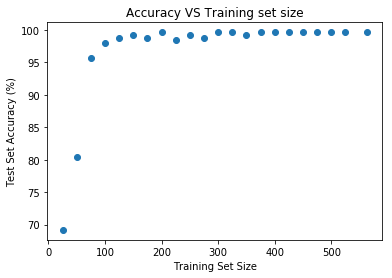

In [81]:
%matplotlib inline
plt.scatter(sizes, test_accuracies)
plt.title('Accuracy VS Training set size')
plt.ylabel('Test Set Accuracy (%)')
plt.xlabel('Training Set Size')
plt.show()

In [86]:
layer0_weights[0].get_shape()

TensorShape([Dimension(30), Dimension(1), Dimension(1)])

In [87]:
layer0_weights[1].get_shape()

TensorShape([Dimension(35), Dimension(1), Dimension(1)])

### Redefining the first model...

In [89]:
graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, sum(m*n for m,n in zip(M, N)), 1))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, 1))
    tf_valid_dataset = tf.constant(validX, tf.float32)
    tf_valid_labels = tf.constant(validY.reshape(-1,1), tf.float32)
    tf_test_dataset = tf.constant(testX, tf.float32)
    
    layer0_weights = []
    layer0_biases = []
    for k in range(K):
        kind_weights = tf.Variable(tf.truncated_normal([M[k], 1, hidden_layer_size], stddev=0.1))
        layer0_weights.append(kind_weights)
        
        kind_biases = tf.Variable(tf.zeros([hidden_layer_size]))
        layer0_biases.append(kind_biases)
        
    layer1_weights = tf.Variable(tf.truncated_normal([sum(N[k]*hidden_layer_size for k in range(K)), 1], stddev=0.1)) 
    layer1_biases = tf.Variable(tf.zeros([1]))
    
    def model(data):
        hidden_list = []
        for k in range(K):
            idx = sum(N[_k]*M[_k] for _k in range(0, k))
            next_idx = N[k]*M[k] + idx
            kind_conv = tf.nn.conv1d(data[:, idx:next_idx], layer0_weights[k], M[k], padding='VALID')
            kind_hidden = tf.nn.relu(kind_conv + layer0_biases[k])
            hidden_list.append(kind_hidden)

        hidden = tf.reshape(tf.concat(hidden_list, 1), (-1, sum(N[k]*hidden_layer_size for k in range(K))))
        logits = tf.matmul( hidden, layer1_weights) + layer1_biases
        return logits
    
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))    
    optimizer = tf.train.MomentumOptimizer(0.1, 0.7).minimize(loss)
    
    train_prediction = tf.nn.sigmoid(logits)
    valid_prediction = tf.nn.sigmoid(model(tf_valid_dataset))
    test_prediction = tf.nn.sigmoid(model(tf_test_dataset))
    
    train_accuracy = 1 - tf.reduce_mean(tf.square((tf.round(train_prediction) - tf_train_labels)))
    valid_accuracy = 1 - tf.reduce_mean(tf.square((tf.round(valid_prediction) - tf_valid_labels)))
#     test_accuracy = tf.reduce_sum(tf.square((tf.round(test_prediction) - tf)))    


In [90]:
sizes = []
test_accuracies = []
for size in [563]+list(range(525, 0, -25)):
    print(size)
    idx = np.random.choice(np.arange(563), replace=False, size=[size])
    trainXSmaller = trainX[idx]
    trainYSmaller = trainY[idx]
    num_steps = 10001
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (trainYSmaller.shape[0] - batch_size)
            batch_data = trainXSmaller[offset:(offset+batch_size)]
            batch_labels = trainYSmaller[offset:(offset+batch_size)]
            feed_dict = {tf_train_dataset: batch_data, 
                         tf_train_labels: batch_labels}
            _, l, batch_pred = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    #         print('normalizer ', normalizer.eval())


            if step % 200 == 0:
                pass
#                 print('Minibatch loss at step %d: %f' % (step, l))
#                 print('Minibatch accuracy: %.1f%%' % (accuracy(batch_labels, batch_pred)*100))
#                 print('Validation accuracy: %.1f%%' % (valid_accuracy.eval()*100))
    #             print('bias ', layer1_biases.eval())
    #             print(np.ravel(layer0_weights[0].eval()))
    #             print(np.ravel(layer0_weights[1].eval()))

        print('Test accuracy: %.1f%%' % (accuracy(testY,test_prediction.eval())*100))       
        print('Test ROC AUC: %.1f%%' % (roc_auc_score(testY, test_prediction.eval())*100))
        sizes.append(size)
        test_accuracies.append(accuracy(testY,test_prediction.eval())*100)

563
Test accuracy: 99.6%
Test ROC AUC: 100.0%
525
Test accuracy: 99.6%
Test ROC AUC: 100.0%
500
Test accuracy: 99.6%
Test ROC AUC: 100.0%
475
Test accuracy: 99.6%
Test ROC AUC: 100.0%
450
Test accuracy: 99.2%
Test ROC AUC: 100.0%
425
Test accuracy: 99.2%
Test ROC AUC: 100.0%
400
Test accuracy: 99.6%
Test ROC AUC: 100.0%
375
Test accuracy: 99.6%
Test ROC AUC: 100.0%
350
Test accuracy: 98.0%
Test ROC AUC: 100.0%
325
Test accuracy: 99.2%
Test ROC AUC: 100.0%
300
Test accuracy: 98.0%
Test ROC AUC: 99.9%
275
Test accuracy: 96.8%
Test ROC AUC: 99.5%
250
Test accuracy: 98.4%
Test ROC AUC: 100.0%
225
Test accuracy: 96.4%
Test ROC AUC: 99.8%
200
Test accuracy: 96.0%
Test ROC AUC: 99.7%
175
Test accuracy: 94.8%
Test ROC AUC: 98.9%
150
Test accuracy: 88.4%
Test ROC AUC: 92.4%
125
Test accuracy: 52.8%
Test ROC AUC: 54.1%
100
Test accuracy: 59.6%
Test ROC AUC: 59.1%
75
Test accuracy: 51.6%
Test ROC AUC: 53.5%
50
Test accuracy: 50.8%
Test ROC AUC: 48.7%
25
Test accuracy: 52.8%
Test ROC AUC: 51.1%


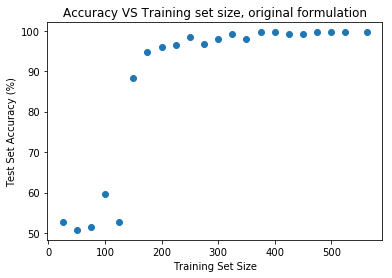

In [91]:
%matplotlib inline
plt.scatter(sizes, test_accuracies)
plt.title('Accuracy VS Training set size, original formulation')
plt.ylabel('Test Set Accuracy (%)')
plt.xlabel('Training Set Size')
plt.show()

In [92]:
improved_accuracies = [99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 
                       99.2, 99.6, 99.6, 98.8, 99.2, 98.4, 99.6, 98.8, 
                       99.2, 98.8, 98.0, 95.6, 80.4, 69.2]

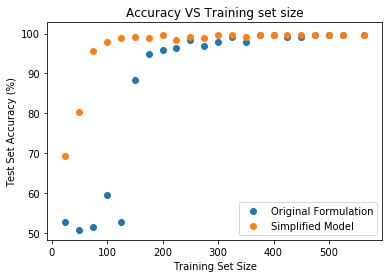

In [94]:
%matplotlib inline
plt.scatter(sizes, test_accuracies, label='Original Formulation')
plt.scatter(sizes, improved_accuracies, label='Simplified Model')
plt.title('Accuracy VS Training set size')
plt.ylabel('Test Set Accuracy (%)')
plt.xlabel('Training Set Size')
plt.legend(loc='lower right')
plt.show()